# Gaussian Processes for Bayesian Optimisation
## From Scratch 

In [7]:
%load_ext nb_black
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
from typing import Union, List
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# For GPs
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    DotProduct,
    WhiteKernel,
    RBF,
    ExpSineSquared,
)

plt.rcParams["font.size"] = 15
plt.rcParams["figure.figsize"] = (14, 6)

<IPython.core.display.Javascript object>

## Objective function to maximise

Optima: x=0.9, y=0.81


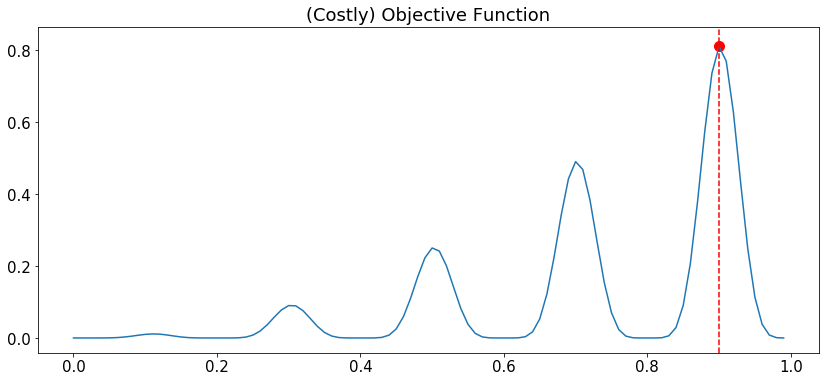

<IPython.core.display.Javascript object>

In [3]:
def objective(x: Union[float, np.ndarray], noise_std: float = 0.0):
    noise = np.random.normal(loc=0, scale=noise_std)
    return (x ** 2 * np.sin(5 * np.pi * x) ** 6.0) + noise


# grid-based sample of the domain [0,1]
X = np.arange(start=0, stop=1, step=0.01)
y = objective(X)

print(f"Optima: x={X[np.argmax(y)]}, y={y[np.argmax(y)]}")

plt.plot(X, y)
plt.scatter(X[np.argmax(y)], y[np.argmax(y)], color="r", s=100)
plt.axvline(x=X[np.argmax(y)], ymin=0, ymax=1, color="r", linestyle="--")
plt.title("(Costly) Objective Function")
plt.show()

## Step 1: Sample the domain sparsely

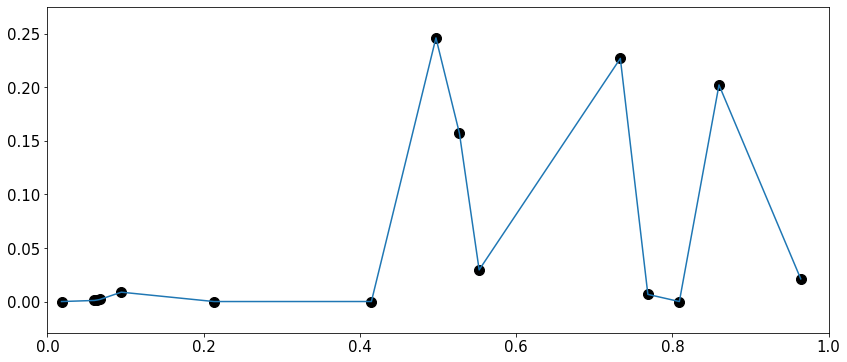

<IPython.core.display.Javascript object>

In [13]:
X_search = np.sort(np.random.rand(15))
y_search = objective(X_search)

plt.scatter(X_search, y_search, color="k", s=100)
plt.plot(X_search, y_search)
plt.xlim([0, 1])
plt.show()

## Step 2: Estimate the function values at all other locations

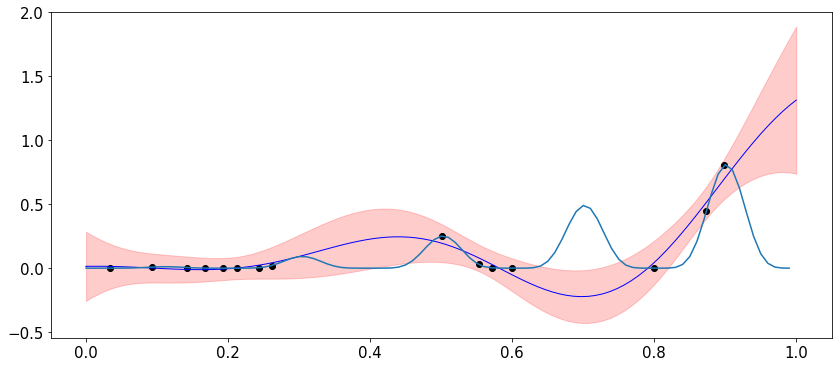

<IPython.core.display.Javascript object>

In [9]:
# kernel = RBF(length_scale=0.25)
kernel = ExpSineSquared()
# kernel = None
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.01)

gp.fit(X_search.reshape(-1, 1), y_search)


X_ = np.linspace(start=0, stop=1, num=100)
X_ = np.sort(np.append(X_, y_search))
y_pred_mean, y_pred_std = gp.predict(X_.reshape(-1, 1), return_std=True)

plt.plot(X_, y_pred_mean, "b", lw=1)
plt.fill_between(
    X_,
    y_pred_mean - 2 * y_pred_std,
    y_pred_mean + 2 * y_pred_std,
    alpha=0.2,
    color="r",
)

plt.plot(X, y)
plt.scatter(X_search, y_search, color="k")

## Step 3: Find the Next Place to Sample




#### Acquisition Functions

* Probability of Improvement (PI)
* Expected Improvement (EI)
* Lower Confdence Bound (LCB).
* Thompson Sampling


\begin{align}
x_{t+1} = {} & \textrm{argmax}\left\{ P \left( \, f(x) \ge f(x^+) + \epsilon  \right) \right\}
\end{align}


Since we are using GPs 


\begin{align}
x_{t+1} = {} & \textrm{argmax}\left\{ \textsf{CDF} \left(  \frac{\mu_t(x) - f(x^+) - \epsilon}{\sigma_t(x)  } \right) \right\}
\end{align}

In [14]:
# probability of improvement acquisition function
def acquisition(X, Xsamples, model) -> float:
    # calculate the best surrogate score found so far
    yhat, _ = model.predict(Xsamples.reshape(-1, 1), return_std=True)
    best = np.max(yhat)

    # calculate mean and stdev via surrogate function
    mu, std = model.predict(X.reshape(-1, 1), return_std=True)

    eps = 0.075
    # calculate the probability of improvement
    probs = stats.norm.cdf((mu - best - eps) / (std + 1e-9))

    x_next = X[np.argmax(probs)]

    return x_next

<IPython.core.display.Javascript object>

## Step 4: Repeat until Convergence

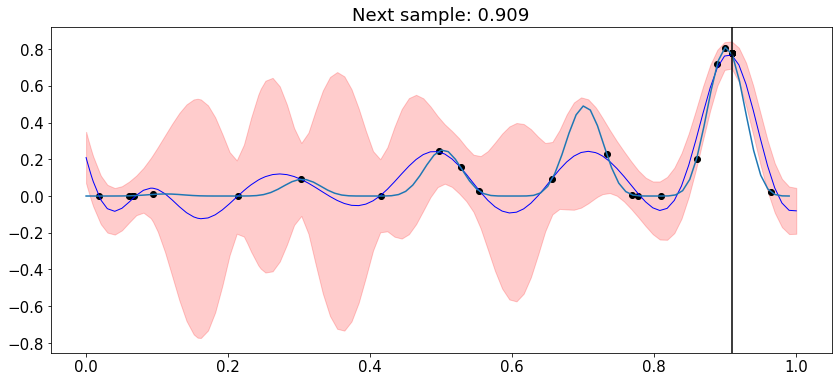

<IPython.core.display.Javascript object>

In [26]:
X_ = np.linspace(start=0, stop=1, num=100)
X_ = np.sort(np.append(X_, y_search))
y_pred_mean, y_pred_std = gp.predict(X_.reshape(-1, 1), return_std=True)

# Find next sample
x_next = acquisition(X_, X_search, gp)

# Append it to the search space
X_search = np.append(X_search, x_next)
y_search = objective(X_search)

# Fit the model
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.01)
gp.fit(X_search.reshape(-1, 1), y_search)


# Plit
plt.plot(X_, y_pred_mean, "b", lw=1)
plt.fill_between(
    X_,
    y_pred_mean - 2 * y_pred_std,
    y_pred_mean + 2 * y_pred_std,
    alpha=0.2,
    color="r",
)


plt.plot(X, y)
plt.scatter(X_search, y_search, color="k")

plt.axvline(x=x_next, ymin=0, ymax=1, color="k")
plt.title(f"Next sample: {x_next.round(3)}")
plt.show()

### References 

* https://machinelearningmastery.com/what-is-bayesian-optimization/
* http://krasserm.github.io/2018/03/21/bayesian-optimization/
* https://distill.pub/2020/bayesian-optimization/